In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import ndimage

### Define Residual Measure

* Imperceptibility: Peak Signal of Noise Ratio(PSNR)
    * $ PSNR = 10lg(\frac{255^2}{MSE}) $
    * $ MSE = \frac{1}{M\cdot N} \sum_1^M\sum_1^N (Img(x,y) - Img^*(x,y))^2 $
* Robustness: Bit Error Rate(BER)
    * $ BER = \frac{1}{P} \sum_{j=1}^{P} |w(j) - w^*(j)| $

BER: 0.09156582324899157 PSNR bgr: {'PSNR': array([37.01982985, 40.70521579, 39.9551353 ])}


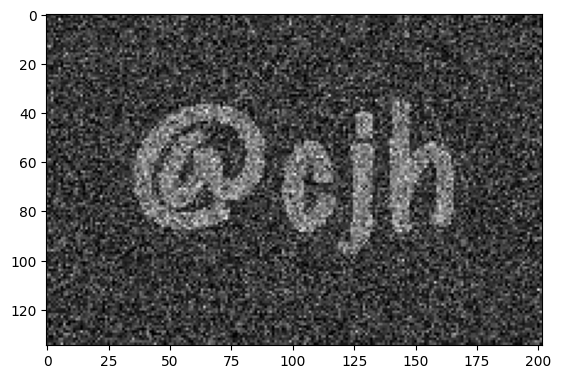

In [481]:
import torch
from importlib import reload
from torch.nn import Sequential
from torchvision import transforms
import models
models = reload(models)

# define src img
src = cv.imread('data/flower.jpg')
wm = cv.imread('wm_gray.png', cv.IMREAD_GRAYSCALE)

# embed
bwm = models.BlindWatermark(password_wm=1, password_img=1)
measures = {}
dst = bwm.embed(src, wm, wm_content='wm_gray.png', measures=measures)
cv.imwrite('data/dst.jpg', dst, [cv.IMWRITE_JPEG_QUALITY, 40])
dst = cv.imread('data/dst.jpg')

# # attack
# attacks = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomRotation(1, interpolation=transforms.InterpolationMode.BILINEAR),
# ])
# dst = attacks(dst)
# dst = np.round(dst.numpy().transpose(1,2,0) * 255).astype(int)
# plt.imshow(dst[:, :, [2,1,0]])

# extract
wm_restore = bwm.extract(dst, out_wm_name='data/wm_restore.png')
plt.imshow(wm_restore, cmap=plt.cm.gray)

# measure
ber = models.ImageMeasure.BER(wm > 127, wm_restore > 127)
print('BER:', ber, 'PSNR bgr:', measures)

### Direct DWT DCT watermark

* choose blocks by ORB and DCT coefficient value
* a, h, v, d = DWT(block)
* freq_domain_blocks = DCT(split_as_8x8_blocks(compose(h, v, d))
* for each blocks: cB, cG = sum(get_freq_band_value(blue_block, 6)), sum(get_freq_band_value(green_block, 6))
* cB = embed_bit(cB, cG, bit)
* inverse DCT / DWT to get embeded image

#### WM Strength

For WM strength, according Paseval theorem, $\int f^2(t) dt = \int F^2(jw) dw$, each unit of WM strength means how much energy will spread into the 8x8 JPEG block using related cosine function.

#### Quantization Resolution Loss

embedding method:
* img -= 127
* split image to JPEG 8x8 blocks
* DCT above image blocks to get freq domain amplitudes
* choose top `wm_bits` blocks which with bigger DCT coefficients sum respectively
* embedding 1 bit using the comparing method mentioned in [Tencent](https://arxiv.org/pdf/2209.13206.pdf)
* then I fall in with quantization trouble, the WM strength always too low, down to WM info loss and freq mixture
    * An appropriate solution seems to choose a series right freq to compose a WM freq domain component whose coefficients in spacial domain is or nearly is integer.

So above problem became:
Give you 64 8x8 JPEG block, which represent each DCT freq with 1 energy in 8x8 2-dim matrix respectively, and get their IDCT as backup.
For Each block which need to insert wm bits, choose the best compound mode to minimize the residual with round operator.

$$ Residual(F(jw)) = IDCT(F(jw)) - round(IDCT(F(jw)))$$
$$ \int F^2(jw) dw = |Strength|^2 $$
$$ Residual Strength = \int Residual^2(F(jw)) dt $$

Since the strength generally only can be integer, and the strength is finite, so we can calculate the optimal compound mode in advance.

已知有 15 个可选的频带 freq，现在要选出 N 个频带，使得这 N 个频带的和四舍五入后的误差最小。
* [牛客提问](https://www.nowcoder.com/discuss/440598300392161280)
* [知乎提问](https://www.zhihu.com/question/576950562)

temporary simple solution:
set average value for the top (strength - 2) value, then calc the residual of all choice for the rest 2 strength, select the minimum residual choice, add to the related freq value

Solution 2:计算舍入后的残差，然后对残差进行 DCT，用频谱减去残差，然后计算比特信息是否完整，如果不完整则重新插入，并重复该过程。

In [8]:
# DWT DCT only watermark
from importlib import reload
from models import dwt_dct, base
base, dwt_dct = reload(base), reload(dwt_dct)

def save_img(img: np.ndarray):
    cv.imwrite('data/dst.jpg', img)
    return img

ddwm = dwt_dct.DwtDctBlockWatermark(freq_band_to_be_embedded=6, wm_strength=400)
wm = b'I have to generate a series of static bytes so that deep dive into the error' * 4
# wm = np.random.bytes(1024)
attack = base.chain(
    base.jpeg_compression_attack('data/dst.jpg', 80),
    base.random_scale_attack((1,2)),
    # save_img,
)
measures = ddwm.measure('data/flower.jpg', wm, attack=attack, pretty=False)
print(measures)

[ WARN:0@1971.603] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('data/flower.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [485]:
# ORB DWT DCT watermark
import ujson
import json
from models import dwt_dct, base, ORB
base, dwt_dct, ORB = reload(base), reload(dwt_dct), reload(ORB)


def save_img(img: np.ndarray):
    cv.imwrite('data/dst.jpg', img)
    return img

def tc_attack(img: np.ndarray):
    # attack
    attacks = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
    ])
    dst = attacks(img)
    dst = np.round(dst.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    return dst

ddwm = ORB.AdaptiveRegionSelectionWatermark(freq_band_to_be_embedded=6, wm_strength=400)
wm = np.random.bytes(160)
attack = base.chain(
    base.jpeg_compression_attack('data/dst2.jpg', 80),
    tc_attack,
    # save_img,
)
measure = ddwm.measure('data/src.jpg', wm, pretty=False, save_kp_img='data/kp', attack=attack)
# json.encoder.JSONEncoder(sort_keys=True, indent=2).encode(measure)
with open('data/output.json', 'w') as fp:
    fp.write(json.dumps(measure, indent=2))
measure.pop('sub')
print(measure)

overflow, underflow (302,) (12,) [596 631 726]
overflow, underflow (3,) (18,) [ 9 10 11]
{'PSNR': [56.55850400712268, -1, -1], 'BER': 0.0, 'ChoosingErrorRate': {'sequence': 0.0, 'points': 0.0}}


In [139]:
import math
from scipy import fftpack, fft
import pywt
from functools import cmp_to_key
from functools import reduce
from models import AbstractWatermark, ImageMeasure


def gaussian(x0, y0=None, sigma_x=1, sigma_y=1, A=1):
    # https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function
    if y0 is not None:
        sX, sY = 2*sigma_x, 2*sigma_y
        def func(x, y):
            power = ((x-x0)/sX)**2 + ((y-y0)/sY)**2
            val = A * np.exp(-power)
            return val
        f = func
    else:
        sX = 2*sigma_x
        def func(x):
            power = ((x-x0)/sX)**2
            val = A * np.exp(-power)
            return val
        f = func
    return np.vectorize(f)

def _choose_img_blocks(img: np.ndarray, block_size=8, ax=None, savefile='', capacity=512):
    # Initiate ORB detector
    scaleFactor = 1.1
    max_level = int(math.log(min(img.shape[:2]), scaleFactor) - math.log(31, scaleFactor))
    orb = cv.ORB_create(nlevels=int(max_level), scaleFactor=scaleFactor)
    # find the keypoints with ORB
    kp = list(orb.detect(img,None))
    for i in range(len(kp)-1):
        if kp[i] is None:
            continue
        for n in range(len(kp)-1-i):
            if kp[i+1+n] is None:
                continue
            if cv.KeyPoint.overlap(kp[i], kp[i+1+n]) != 0:
                if kp[i].response >= kp[i+1+n].response:
                    kp[i+1+n] = None
                else:
                    kp[i] = None
                    break
    kp = list(filter(lambda x: x is not None, kp))

    # get square area block indices and area itself
    M, N = img.shape[0]//block_size, img.shape[1]//block_size
    pt = [np.array((x.pt[1], x.pt[0], x.size/np.sqrt(2))) for x in kp]
    pt = np.array([(x[0]-x[2]/2, x[1]-x[2]/2, x[2]) for x in pt])
    block_indices, area, cp = [], [], 0
    for i, p in enumerate(np.round(pt//block_size).astype(int)):
        r, c = np.indices((p[2], p[2]))
        r, c = p[0] + r, p[1] + c
        indices = r*N+c
        block_indices.append(indices)
        cp += len(block_indices)

        p *= block_size
        a = img[p[0]:p[0]+p[2], p[1]:p[1]+p[2]]
        area.append(a)
    assert cp >= capacity, 'capacity not matched: {} < {}'.format(cp, capacity)

    # sort area by its robustness coefficient
    area_dct = [fftpack.dctn(a, axes=(0,1)) for a in area]
    Ef = np.array([np.abs(a).sum() / np.prod(a.shape[:2]) for a in area_dct])
    Rf = np.array([(np.abs(a) > 1).sum() / np.prod(a.shape[:2]) for a in area_dct])
    Si = Ef + Rf + Ef*Rf
    sorted_idx = sorted(range(len(kp)), key=lambda x: Si[x], reverse=True)

    # plot and save
    img2 = cv.drawKeypoints(img, kp[60:62], None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if ax is not None:
        ax.imshow(img2);plt.axis('off');
    if savefile:
        cv.imwrite(savefile, img2)

    sorted_kp, sorted_indices, cp = *list(zip(*[(kp[idx], block_indices[idx])for idx in sorted_idx])), cp
    for k in sorted_kp:
        print(k.response)
    return sorted_kp, sorted_indices, cp

def _calc_uint8_precision_loss(blocks: np.ndarray, debug=False):
    errors = {}
    # calc precision loss
    base_u8 = np.round(blocks)
    under, over = base_u8[base_u8 < 0], base_u8[base_u8 > 255]
    errors['PrecisionLoss(over,under)'] =\
        (over.size, over.mean()) if len(over) else None, (under.size, under.mean()) if len(over) else None
    if debug:
        print('PrecisionLoss(over,under):', errors['PrecisionLoss(over,under)'])
    # # get precision loss index
    # under_idx = np.argwhere((base_u8 < 0).sum(axis=(-2,-1))).flatten()
    # over_idx = np.argwhere((base_u8 >= 255).sum(axis=(-2,-1))).flatten()
    # # test
    # u = under_idx[0]
    # prev, cur = dct_blocks_backup[0, u], dct_blocks[0, u]
    # print((10*(dct_blocks_backup[0, u] - dct_blocks_backup[1, u])).astype(int))
    # print((prev*10).astype(int) - (cur*10).astype(int))
    return errors

def _calc_quantization_loss(base: np.ndarray, debug=False):
    errors = {}
    # calc quantization loss
    residual = base - np.round(base)
    errors['Quantization loss(single pixel loss)'] = abs(residual).mean()
    if debug:
        print('Quantization loss(single pixel loss):', errors['Quantization loss(single pixel loss)'])
    return errors

_dctn = lambda ar: fftpack.dctn(ar, norm='ortho', axes=(-2,-1))
_idctn = lambda ar: fftpack.idctn(ar, norm='ortho', axes=(-2,-1))
_idwt2 = lambda ar: pywt.idwt2((ar[0], ar[1:]), 'haar')

def _to_pixel_range(x):
    shape = x.shape
    x = x.flatten()
    cond = x > 128; x[cond] = 128
    cond = x <-127; x[cond] = -127
    cond = x > 0; x[cond] = np.floor(x[cond])
    cond = x < 0; x[cond] = np.ceil(x[cond])
    return x.reshape(shape)
# _to_pixel_range = np.vectorize(_to_pixel_range)

def _dwt2(ar: np.ndarray):
    a, (h,v,d) = pywt.dwt2(ar, 'haar')
    return np.array([a,h,v,d])


def _to_blocks(src: np.ndarray, block_size=8):
    assert len(src.shape) == 3
    # split img as blocks
    M, N = block_size, block_size
    shape = src.shape[0]//M, src.shape[1]//N, M, N
    blocks = src.reshape((shape[0], M, shape[1], N, src.shape[-1])).transpose(4, 0, 2, 1, 3)
    blocks = blocks.reshape(src.shape[-1], blocks.shape[1]*blocks.shape[2], M, N)
    return blocks   # 3xrowxcolx8x8

class DwtDctWatermark(AbstractWatermark):
    _chosen_block_indices = None
    _wavelet_component_index = 0    # a h v d

    def __init__(
            self,
            jpeg_block_size=8,
            arnold_coefficients=(1,1, 6),
            freq_band_to_be_embedded=6,
            wm_strength=16,
            debug=False,
            quantization_residual=None,
    ):
        self.jpeg_block_size = jpeg_block_size
        self.arnold_matrix = np.array([
            [1, arnold_coefficients[0]],
            [arnold_coefficients[1], np.prod(arnold_coefficients[:2]) + 1],
        ])
        self.arnold_inverse_matrix = np.array([
            [np.prod(arnold_coefficients[:2]) + 1, -arnold_coefficients[0]],
            [-arnold_coefficients[1], 1],
        ])
        self.arnold_loop = arnold_coefficients[2]
        self.freq_band_to_be_embedded = freq_band_to_be_embedded
        self.wm_strength = wm_strength
        self._debug = debug
        self.quantization_residual = quantization_residual if not debug else True
        self.errors = {}
        super().__init__()

    @staticmethod
    def _from_blocks(blocks: np.ndarray, genesis_shape):
        assert len(genesis_shape) > 2
        # construct img using img blocks
        M, N = blocks.shape[-2], blocks.shape[-1]
        shape = genesis_shape[2], genesis_shape[0]//M, genesis_shape[1]//N, M, N
        img = blocks.reshape(shape)    # reshape block to split block size
        img = img.transpose(0, 1, 3, 2, 4) # recover block
        img = img.transpose(1,2,3,4,0)
        img = img.reshape(genesis_shape)
        return img

    @classmethod
    def _serialize_wm(cls, wm: bytes):
        if not isinstance(wm, bytes):
            raise TypeError('wm serializer only support `bytes`')
        wm_bits = np.unpackbits(np.array(list(wm), dtype=np.uint8))
        return wm_bits

    def _embed(self, blocks:np.ndarray, block_indices: np.ndarray, wm_bits: np.ndarray):
        # define
        f = self.freq_band_to_be_embedded // 2
        block_indices_copy = block_indices.copy()
        wm_bits_copy = wm_bits.copy()
        widx = self._wavelet_component_index    # wavelet horizontal

        def _trans(ar: np.ndarray):
            blue, green = _dctn(_dwt2((ar))).transpose(1,0,2,3,4)
            return blue, green

        def _itrans(blue: np.ndarray, green: np.ndarray):
            res = _idctn(np.array([blue, green]).transpose(1,0,2,3,4))
            res = _idwt2(res)
            return res

        max_embedding_trying = 9
        blue = None
        for i in range(max_embedding_trying):
            if len(wm_bits) == 0:
                break
            # DWT & DCT
            blue, green = _trans(blocks[:2, block_indices])
            # embed
            cB = (blue[widx, :, f, :]).sum(axis=-1) + (blue[widx, :, :, f]).sum(axis=-1)
            cG = (green[widx, :, f, :]).sum(axis=-1) + (green[widx, :, :, f]).sum(axis=-1)
            dB = cB - cG
            cond1 = np.bitwise_and(wm_bits == True, cB - self.wm_strength <= cG)
            dB[cond1] = -dB[cond1] + self.wm_strength
            cond_1 = np.bitwise_and(wm_bits == False, cB + self.wm_strength >= cG)
            dB[cond_1] = -dB[cond_1] - self.wm_strength
            # get wm strength weight for each freq
            weight = np.ones(blue.shape[-1])
            weight[f] = 0.5
            weight /= (weight.sum()*2 - 1)
            val = dB[:, None] @ weight[None, :]
            blue[widx, :, f, :] += val
            blue[widx, :, :, f] += val

            # IDCT & IDWT
            blocks[:2, block_indices] = _itrans(blue, green)

            # Counteract deviation, rounding、uint8 overflow
            b = blocks[0, block_indices]
            cond = np.bitwise_or(cond1, cond_1)
            over_idx = np.argwhere(np.bitwise_and((b > 128).sum(axis=(-2,-1)) > 0, cond)).flatten()
            under_idx = np.argwhere(np.bitwise_and((b < -127).sum(axis=(-2,-1)) > 0, cond)).flatten()
            precision_idx = np.hstack((over_idx, under_idx))
            blocks[0, block_indices] = _to_pixel_range(blocks[0, block_indices])
            # update
            block_indices = block_indices[precision_idx]
            wm_bits = wm_bits[precision_idx]

        # # test wm restore
        # blue, green = _trans(blocks[:2, block_indices_copy])
        # # embed
        # cB = (blue[widx, :, f, :]).sum(axis=-1) + (blue[widx, :, :, f]).sum(axis=-1)
        # cG = (green[widx, :, f, :]).sum(axis=-1) + (green[widx, :, :, f]).sum(axis=-1)
        # res = cB > cG
        # print('error rate:', (res != wm_bits_copy).sum(), len(wm_bits_copy))

        return blocks

    def _extract(self, blocks: np.ndarray, block_indices: np.ndarray, wm_size):
        # define
        f = self.freq_band_to_be_embedded//2
        widx = self._wavelet_component_index  # choose horizontal component

        # DWT & DCT
        blue, green = _dctn(_dwt2((blocks[:2, block_indices]))).transpose(1,0,2,3,4)
        # extract
        cB = (blue[widx, :, f, :]).sum(axis=-1) + (blue[widx, :, :, f]).sum(axis=-1)
        cG = (green[widx, :, f, :]).sum(axis=-1) + (green[widx, :, :, f]).sum(axis=-1)
        cond = cB > cG
        wm = cond.astype(np.uint8)

        return wm

    def _process(self, src: np.ndarray, wm_bits: np.ndarray=None, jpeg_block_size=None, wm_size=None, ax=None, *args, **kwargs):
        # global
        block_size = jpeg_block_size or self.jpeg_block_size
        assert len(src.shape) >=3, 'only support colorful image'
        assert all([x % block_size == 0 for x in src.shape[:2]]), 'image size must can be divided by jpeg_block_size'

        # split img as blocks
        blocks = _to_blocks(src, block_size=block_size).astype(float) - 127

        # choose image blocks using ORB and texture
        _, indices, _ = _choose_img_blocks(src, block_size=block_size, capacity=wm_size, savefile='embed.jpg' if wm_bits is not None else 'extraction.jpg')
        indices = np.array(reduce(lambda x, y: np.hstack((x.flatten(), y.flatten())), indices))
        assert indices.size == len(set(indices)), \
            '{} != {}, all of the block indices must be unique'.format(indices.size, len(set(indices)))
        block_indices = indices[:wm_size]
        # [extraction]calc choosing error
        if wm_bits is not None:
            self._chosen_block_indices = block_indices
        else:
            assert self._chosen_block_indices.shape == block_indices.shape
            assert self._chosen_block_indices.dtype == block_indices.dtype
            self.errors['ChoosingErrorRate(Sequence)'] = (self._chosen_block_indices != block_indices).sum()/block_indices.size
            self.errors['ChoosingErrorRate(Points)'] = len(set(self._chosen_block_indices) ^ set(block_indices))/block_indices.size
            if self._debug:
                print(
                    'ChoosingErrorRate(Sequence, Points):',
                    self.errors['ChoosingErrorRate(Sequence)'],
                    self.errors['ChoosingErrorRate(Points)'],
                )

        # embed watermark
        if wm_bits is not None:
            self._embed(blocks, block_indices, wm_bits)
        else:
            wm_restore = self._extract(blocks, block_indices, wm_size=wm_size)
            return wm_restore

        # calc quantization loss
        self.errors.update(_calc_quantization_loss(blocks[0, block_indices], debug=self._debug))
        # calc precision loss
        self.errors.update(_calc_uint8_precision_loss(blocks[0, block_indices]+127, debug=self._debug))

        dst = np.round(self._from_blocks(blocks, src.shape) + 127).astype(np.uint8)
        return dst

    def embed(self, src: np.ndarray, wm, jpeg_block_size=None, *args, **kwargs):
        wm_bits = self._serialize_wm(wm)
        img_max_capacity = np.prod([x // 8 for x in src.shape[:2]]) / 4
        if wm_bits is not None:
            assert len(wm_bits) <= img_max_capacity,\
                'wm_bits > img_max_capacity: {} > {}'.format(len(wm_bits), img_max_capacity)
        return self._process(src, wm_bits=wm_bits, jpeg_block_size=jpeg_block_size, wm_size=wm_bits.size, *args, **kwargs)

    def extract(self, src: np.ndarray, jpeg_block_size=None, wm_size=None, refer=None, *args, **kwargs):
        wm_bits = self._process(src, jpeg_block_size=jpeg_block_size, wm_size=wm_size*8)

        if refer:
            wm_refer = self._serialize_wm(refer)
            diff = wm_bits != wm_refer
            # print(np.argwhere(diff))
            self.errors['BitErrorRate'] = diff.sum() / diff.size
            if self._debug:
                print('BitErrorRate:', self.errors['BitErrorRate'])

        wm_bits = np.packbits(wm_bits).tobytes()
        return wm_bits

# define
wm = np.random.bytes(128)
src = cv.imread('flower.jpg')

# embed
ddwm = DwtDctWatermark(freq_band_to_be_embedded=6, wm_strength=800, debug=True, quantization_residual=True)
dst = ddwm.embed(src, wm)

# get PSNR
PSNR = ImageMeasure.PSNR(src, dst)
print('Image PSNR:', PSNR)
cv.imwrite('dst.jpg', dst, [cv.IMWRITE_JPEG_QUALITY, 40])

# # attack
# attacks = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomRotation(1, interpolation=transforms.InterpolationMode.BILINEAR, fill=127),
# ])
# dst = attacks(dst)
# dst = (dst.numpy().transpose(1,2,0) * 255).astype(np.uint8)
# plt.imshow(dst[:, :, [2,1,0]])
# cv.imwrite('dst.jpg', dst)

# extract
dst = cv.imread('dst.jpg')
wm_restore = ddwm.extract(dst, wm_size=len(wm), refer=wm)

[ WARN:0@11839.563] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('flower.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [752]:
# 尝试对 ORB 后的特征进行聚类，但是失败了，偏差太大
from scipy import cluster
from models import dwt_dct, base, ORB
base, dwt_dct, ORB = reload(base), reload(dwt_dct), reload(ORB)


def save_img(img: np.ndarray):
    cv.imwrite('dst.jpg', img)
    return img

def tc_attack(img: np.ndarray):
    # attack
    attacks = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(5, interpolation=transforms.InterpolationMode.BILINEAR),
    ])
    dst = attacks(img)
    dst = np.round(dst.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    return dst

def _get_img_key_points(img: np.ndarray, ax=None, savefile='', draw_first=500, capacity=1024):
    scaleFactor = 1.1
    max_level = int(math.log(min(img.shape[:2]), scaleFactor) - math.log(31, scaleFactor))
    orb = cv.ORB_create(nlevels=int(max_level), scaleFactor=scaleFactor, firstLevel=0)
    brisk = cv.BRISK_create(octaves=7)
    sift = cv.SIFT_create()
    akaze = cv.AKAZE_create(nOctaves=32, nOctaveLayers=8)
    detector = akaze
    # classify key points
    kp = detector.detect(img, None)
    kp_backup = list(kp)
    kp = kp_backup.copy()

    # NMS
    for i in range(len(kp)-1):
        if kp[i] is None:
            continue
        for n in range(len(kp)-1-i):
            if kp[i+1+n] is None:
                continue
            if cv.KeyPoint.overlap(kp[i], kp[i+1+n]) != 0:
                if kp[i].response >= kp[i+1+n].response:
                    kp[i+1+n] = None
                else:
                    kp[i] = None
                    break
    NMS_kp = sorted(filter(lambda x: x is not None and x.size >= 46, kp), key=lambda x: x.response, reverse=True)
    # #
    # NMS_kp_cluster = []
    # threshold = 0.6
    # for nms_k in NMS_kp:
    #     cluster = []
    #     for k in kp_backup:
    #         rate = cv.KeyPoint.overlap(nms_k, k)
    #         if rate > threshold:
    #             cluster.append(k)
    #     NMS_kp_cluster.append(cluster)

    # plot and save
    img2 = cv.drawKeypoints(img, NMS_kp[:], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if ax is not None:
        ax.imshow(img2);ax.axis('off')
    if savefile:
        cv.imwrite(savefile, img2)

    pt = np.array([[*x.pt, x.size, x.angle, x.response] for x in NMS_kp])
    return pt

attack = base.chain(
    base.jpeg_compression_attack('dst.jpg', 50),
    tc_attack,
    save_img,
)

n = 5
src = cv.imread('data/flower.jpg')
key_points = _get_img_key_points(src, savefile='data/kp1.jpg', draw_first=n);
dst = attack(src)
key_points2 = _get_img_key_points(dst, savefile='data/kp2.jpg', draw_first=n);

key_points[:n] - key_points2[:n]

array([[-5.81738281e+00, -5.24703979e+00,  0.00000000e+00,
        -3.44448853e+00,  4.32759523e-04],
       [-8.17871094e-02, -7.95635986e+00,  0.00000000e+00,
        -1.32446289e-01,  3.21051106e-04],
       [ 6.12963867e+00, -8.89538574e+00,  0.00000000e+00,
        -7.00286865e-01,  1.14204362e-04],
       [-5.37939453e+00, -4.35186768e+00,  0.00000000e+00,
        -5.72723389e-01,  2.53070612e-04],
       [ 2.39038086e+00, -6.41931152e+00,  0.00000000e+00,
        -1.08526611e+00,  1.78613234e-04]])

In [921]:
from scipy import interpolate
dst = interpolate.interp2d

(1840, 3264, 3)